In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder


### Training model to predict probability of hotel being booked

In [2]:
df = pd.read_csv('training_preprocessed.csv')
df.head()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_brand_bool,prop_location_score1,prop_log_historical_price,position,...,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,random_bool,click_bool,booking_bool,month
0,1,11,7,15,893,3,1,2.83,4.95,27,...,1,0,4,0,1,1,1,0,0,4
1,1,11,7,15,10404,4,1,2.20,5.03,26,...,1,0,4,0,1,1,1,0,0,4
2,1,11,7,15,21315,3,1,2.20,4.92,21,...,1,0,4,0,1,1,1,0,0,4
3,1,11,7,15,27348,2,1,2.83,4.39,34,...,1,0,4,0,1,1,1,0,0,4
4,1,11,7,15,29604,4,1,2.64,4.93,4,...,1,0,4,0,1,1,1,0,0,4


In [3]:
df.columns

Index(['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool',
       'month'],
      dtype='object')

In [4]:
X = df.drop(['booking_bool','position','random_bool','prop_id'], axis=1)
y = df['booking_bool']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# save click_bool and srch_id from test
click_list = X_test['click_bool']
srchid_list = X_test['srch_id']


# remove click_bool and srch_id from train and test
X_train = X_train.drop(['click_bool', 'srch_id'], axis=1)
X_test = X_test.drop(['click_bool', 'srch_id'], axis=1)

## Random forest  to determine probability of hotel being booked 

In [7]:
rm = RandomForestClassifier(criterion='gini', max_depth=8,min_samples_split=2, n_estimators=50)
# predict probabilities on validation
rm_model = rm.fit(X_train, y_train)
y_rm_pred = rm_model.predict_proba(X_test)

In [8]:
# print evaluation measures
# AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss

rm_auc = roc_auc_score(y_test,y_rm_pred[:,1])
# log_loss
rm_log_loss = log_loss(y_test, y_rm_pred)

print('The Random Forest AUC score is %.3f'% rm_auc)
print('The Random Forest log loss is  %.3f' % rm_log_loss)

y_pred = rm.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix

Confusion_Matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted no', 'Predicted yes'],
    index=['True no', 'True yes'])

print(Confusion_Matrix)

# understand which features matter the most
rm_importance = pd.DataFrame({'feature':X_train.columns,'importance':(rm_model.feature_importances_).ravel()})
rm_importance.sort_values(by='importance', ascending=False)

The Random Forest AUC score is 0.629
The Random Forest log loss is  0.125
          Predicted no  Predicted yes
True no         963904              0
True yes         27766              0


,feature,importance
8,promotion_flag,0.242450
9,srch_destination_id,0.170789
3,prop_starrating,0.108813
10,srch_length_of_stay,0.097166
11,srch_booking_window,0.089969
5,prop_location_score1,0.065650
6,prop_log_historical_price,0.060173
7,price_usd,0.027426
12,srch_adults_count,0.025992
2,prop_country_id,0.024327


<Axes: >

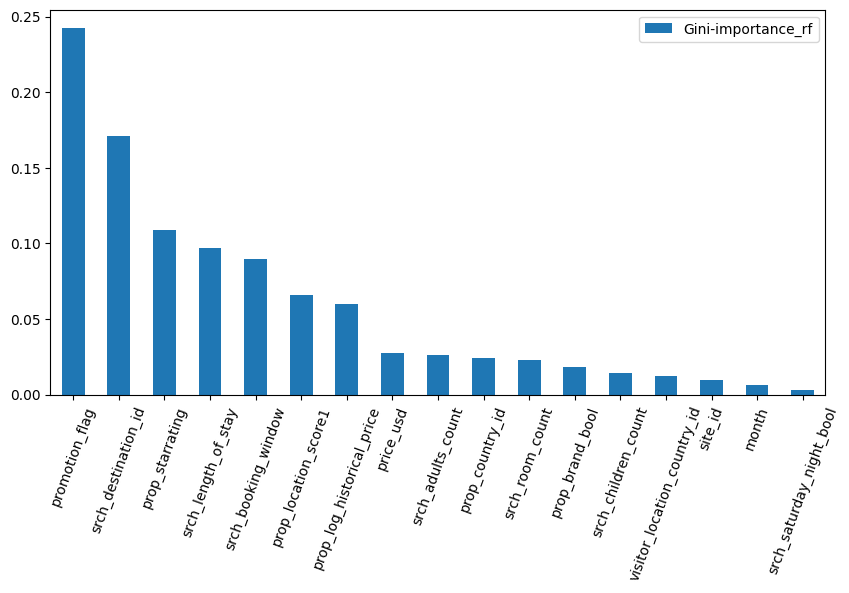

In [9]:
# output feature importance from random forests
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, rm.feature_importances_):
    feats[feature] = importance #add the name/value pair 
    
importances_rf = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance_rf'})
importances_rf = importances_rf.sort_values('Gini-importance_rf', ascending = False)

importances_rf.plot(kind='bar', figsize=(10,5), rot=70)

### Generate search result table

In [10]:
# generate results
# columns relavent for evaluting performance ran for y_dt_pred, y_rm_pred and y_gb_pred

# combine probability results 
y_pred = pd.DataFrame({'click_bool':click_list,'booking_bool':y_test, 'srch_id':srchid_list, 'prob':y_rm_pred[:,1]})
y_pred['position'] = 0
y_pred = y_pred.reset_index(0, drop=True)

# combine results and search criteria
rank_total = y_pred
rank_total['score'] = rank_total['click_bool']*1 + rank_total['booking_bool']*5

In [11]:
# sort results by probability
rank = rank_total.groupby('srch_id', group_keys=False).apply(lambda x: x.sort_values('prob', ascending=False))

# order hotel displays within each search by probability
rank_order = rank.groupby('srch_id').head(10).reset_index(drop=True)

# adding rank of display by each search
rank_order['position'] = rank_order.groupby(['srch_id'])['position'].rank(method='first').astype(int).astype(str)

In [12]:
rank_order.head()

,click_bool,booking_bool,srch_id,prob,position,score
0,0,0,1,0.030903,1,0
1,0,0,1,0.026860,2,0
2,0,0,1,0.026490,3,0
3,0,0,1,0.026490,4,0
4,0,0,1,0.026400,5,0


# Predicting on test

In [13]:
test_df =  pd.read_csv('test_preprocessed.csv')
prop_ids = test_df['prop_id']
srch_ids = test_df['srch_id']
test_df = test_df.drop(['prop_id', 'srch_id'],axis=1)

In [14]:
test_df.columns


Index(['site_id', 'visitor_location_country_id', 'prop_country_id',
       'prop_starrating', 'prop_brand_bool', 'prop_location_score1',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'month'],
      dtype='object')

In [15]:
y_pred = rm_model.predict_proba(test_df)

In [20]:
prediction_df = pd.concat( [srch_ids, prop_ids] , axis=1)
prediction_df['prob'] = y_pred[:,1]
prediction_df = prediction_df.groupby('srch_id').apply(lambda x: x.sort_values('prob', ascending=False))


In [21]:
# prediction_df = prediction_df.reset_index(drop=True)
prediction_df = prediction_df.drop(['prob'], axis=1)


In [22]:
prediction_df.to_csv('test_predictions.csv', index=False)